In [ ]:
cd//content/drive/MyDrive/Anomaly/open

/content/drive/MyDrive/Anomaly/open


In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 8.9 MB/s 


# 1. 라이브러리 불러오기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


In [ ]:
device = torch.device('cuda')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
'''
glob 
-> Return a list of paths matching a pathname pattern.
'''
train_png = sorted(glob('train/*.png'))  # list
test_png = sorted(glob('test/*.png')) 

In [ ]:
train_labels

[72,
 15,
 72,
 76,
 3,
 76,
 15,
 55,
 4,
 72,
 22,
 33,
 76,
 53,
 9,
 76,
 46,
 76,
 52,
 59,
 82,
 40,
 15,
 54,
 15,
 33,
 3,
 76,
 52,
 68,
 76,
 33,
 9,
 31,
 52,
 56,
 84,
 63,
 9,
 9,
 76,
 21,
 72,
 76,
 55,
 63,
 55,
 45,
 76,
 72,
 21,
 21,
 76,
 2,
 52,
 63,
 28,
 21,
 3,
 76,
 3,
 76,
 28,
 84,
 33,
 55,
 40,
 40,
 55,
 55,
 21,
 84,
 72,
 86,
 40,
 63,
 33,
 40,
 84,
 21,
 15,
 84,
 50,
 21,
 28,
 33,
 52,
 33,
 75,
 31,
 55,
 72,
 47,
 45,
 3,
 60,
 10,
 72,
 84,
 45,
 15,
 9,
 33,
 45,
 47,
 21,
 45,
 33,
 63,
 40,
 18,
 18,
 85,
 13,
 59,
 40,
 68,
 21,
 16,
 68,
 55,
 52,
 45,
 55,
 55,
 33,
 55,
 21,
 84,
 63,
 55,
 84,
 44,
 23,
 33,
 72,
 33,
 55,
 72,
 55,
 72,
 55,
 43,
 72,
 69,
 63,
 72,
 9,
 84,
 40,
 28,
 28,
 33,
 83,
 38,
 63,
 13,
 62,
 9,
 3,
 40,
 33,
 9,
 9,
 21,
 58,
 45,
 55,
 21,
 59,
 63,
 9,
 3,
 33,
 84,
 63,
 68,
 33,
 28,
 40,
 9,
 15,
 83,
 52,
 45,
 33,
 21,
 63,
 28,
 15,
 63,
 45,
 76,
 76,
 84,
 40,
 76,
 57,
 45,
 72,
 32,
 55,
 68,
 33,


In [ ]:
label_unique['transistor-good']

72

# 2. 데이터셋 준비

In [ ]:
tr_df = pd.read_csv('train_df.csv')
train_labels = tr_df['label']

label_unique = sorted(np.unique(train_labels))
label_unique = {key : value for key, value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]
label_unique, train_labels

({'bottle-broken_large': 0,
  'bottle-broken_small': 1,
  'bottle-contamination': 2,
  'bottle-good': 3,
  'cable-bent_wire': 4,
  'cable-cable_swap': 5,
  'cable-combined': 6,
  'cable-cut_inner_insulation': 7,
  'cable-cut_outer_insulation': 8,
  'cable-good': 9,
  'cable-missing_cable': 10,
  'cable-missing_wire': 11,
  'cable-poke_insulation': 12,
  'capsule-crack': 13,
  'capsule-faulty_imprint': 14,
  'capsule-good': 15,
  'capsule-poke': 16,
  'capsule-scratch': 17,
  'capsule-squeeze': 18,
  'carpet-color': 19,
  'carpet-cut': 20,
  'carpet-good': 21,
  'carpet-hole': 22,
  'carpet-metal_contamination': 23,
  'carpet-thread': 24,
  'grid-bent': 25,
  'grid-broken': 26,
  'grid-glue': 27,
  'grid-good': 28,
  'grid-metal_contamination': 29,
  'grid-thread': 30,
  'hazelnut-crack': 31,
  'hazelnut-cut': 32,
  'hazelnut-good': 33,
  'hazelnut-hole': 34,
  'hazelnut-print': 35,
  'leather-color': 36,
  'leather-cut': 37,
  'leather-fold': 38,
  'leather-glue': 39,
  'leather-good':

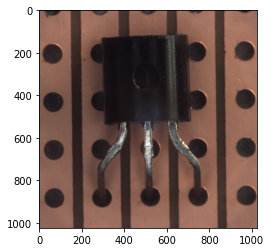

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

'''
::-1 : reverse / BGR -> RGB
- cv2.img가 BGR로 들어오니깐 reverse로 RGB로 만드는 거
- cv2.cvtColor( img, cv2.BGR2RGB)를 대신
'''
img = cv2.imread('./'+train_png[0])[:,:,::-1]  
plt.imshow(img)

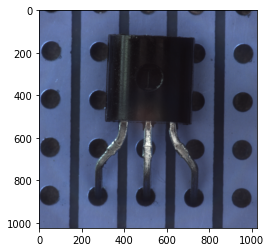

In [ ]:
img = cv2.imread('./'+train_png[0])[:,::-1]  
plt.imshow(img)

In [ ]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512,512))
    return img

In [18]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(m) for m in tqdm(test_png)]


100%|██████████| 4277/4277 [02:55<00:00, 24.34it/s]

100%|██████████| 2154/2154 [21:37<00:00,  1.66it/s]


In [19]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode


    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation == 1:
                img = img[::-1].copy() # vertical flip / B
            elif augmentation == 2:
                img = img[:,::-1].copy() # RG
        img = transforms.ToTensor()(img)
        
        if self.mode == 'test':
            pass

        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.img_paths)

In [20]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=88)

    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
np.array(['tmp']*10)

array(['tmp', 'tmp', 'tmp', 'tmp', 'tmp', 'tmp', 'tmp', 'tmp', 'tmp',
       'tmp'], dtype='<U3')

In [22]:
seed_everything(328)

batch_size = 32
epochs = 25

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset,shuffle=True, batch_size = batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(['tmp'] * len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

  1%|          | 43/4277 [52:08<85:34:02, 72.75s/it]


# 3. 모델 학습

In [23]:

def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):

    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()

    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)

        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


epoch : 1/25    time : 79s/1908s
TRAIN    loss : 0.99569    f1 : 0.22046
epoch : 2/25    time : 77s/1765s
TRAIN    loss : 0.51098    f1 : 0.39310
epoch : 3/25    time : 77s/1688s
TRAIN    loss : 0.38013    f1 : 0.51144
epoch : 4/25    time : 77s/1615s
TRAIN    loss : 0.30776    f1 : 0.60076
epoch : 5/25    time : 77s/1540s
TRAIN    loss : 0.22492    f1 : 0.67949
epoch : 6/25    time : 77s/1460s
TRAIN    loss : 0.17906    f1 : 0.75475
epoch : 7/25    time : 77s/1383s
TRAIN    loss : 0.16320    f1 : 0.78612
epoch : 8/25    time : 77s/1306s
TRAIN    loss : 0.15325    f1 : 0.79990
epoch : 9/25    time : 77s/1230s
TRAIN    loss : 0.10396    f1 : 0.86594
epoch : 10/25    time : 77s/1151s
TRAIN    loss : 0.11474    f1 : 0.85468
epoch : 11/25    time : 77s/1076s
TRAIN    loss : 0.11532    f1 : 0.86830
epoch : 12/25    time : 77s/999s
TRAIN    loss : 0.09025    f1 : 0.88267
epoch : 13/25    time : 77s/921s
TRAIN    loss : 0.09323    f1 : 0.88319
epoch : 14/25    time : 77s/845s
TRAIN    loss : 

# 4. 모델 추론

In [25]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype=torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)

        # list.extend(iterable)는 리스트 끝에 가장 바깥쪽 iterable의 모든 항목을 넣습니다.
        # append는 x 그 자체를 원소로 넣고 extend는 iterable의 각 항목들을 넣습니다
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [40]:
label_unique.items()

dict_items([('bottle-broken_large', 0), ('bottle-broken_small', 1), ('bottle-contamination', 2), ('bottle-good', 3), ('cable-bent_wire', 4), ('cable-cable_swap', 5), ('cable-combined', 6), ('cable-cut_inner_insulation', 7), ('cable-cut_outer_insulation', 8), ('cable-good', 9), ('cable-missing_cable', 10), ('cable-missing_wire', 11), ('cable-poke_insulation', 12), ('capsule-crack', 13), ('capsule-faulty_imprint', 14), ('capsule-good', 15), ('capsule-poke', 16), ('capsule-scratch', 17), ('capsule-squeeze', 18), ('carpet-color', 19), ('carpet-cut', 20), ('carpet-good', 21), ('carpet-hole', 22), ('carpet-metal_contamination', 23), ('carpet-thread', 24), ('grid-bent', 25), ('grid-broken', 26), ('grid-glue', 27), ('grid-good', 28), ('grid-metal_contamination', 29), ('grid-thread', 30), ('hazelnut-crack', 31), ('hazelnut-cut', 32), ('hazelnut-good', 33), ('hazelnut-hole', 34), ('hazelnut-print', 35), ('leather-color', 36), ('leather-cut', 37), ('leather-fold', 38), ('leather-glue', 39), ('lea

In [42]:
label_decoder = {val : key for key, val in label_unique.items()}

label_decoder

{0: 'bottle-broken_large',
 1: 'bottle-broken_small',
 2: 'bottle-contamination',
 3: 'bottle-good',
 4: 'cable-bent_wire',
 5: 'cable-cable_swap',
 6: 'cable-combined',
 7: 'cable-cut_inner_insulation',
 8: 'cable-cut_outer_insulation',
 9: 'cable-good',
 10: 'cable-missing_cable',
 11: 'cable-missing_wire',
 12: 'cable-poke_insulation',
 13: 'capsule-crack',
 14: 'capsule-faulty_imprint',
 15: 'capsule-good',
 16: 'capsule-poke',
 17: 'capsule-scratch',
 18: 'capsule-squeeze',
 19: 'carpet-color',
 20: 'carpet-cut',
 21: 'carpet-good',
 22: 'carpet-hole',
 23: 'carpet-metal_contamination',
 24: 'carpet-thread',
 25: 'grid-bent',
 26: 'grid-broken',
 27: 'grid-glue',
 28: 'grid-good',
 29: 'grid-metal_contamination',
 30: 'grid-thread',
 31: 'hazelnut-crack',
 32: 'hazelnut-cut',
 33: 'hazelnut-good',
 34: 'hazelnut-hole',
 35: 'hazelnut-print',
 36: 'leather-color',
 37: 'leather-cut',
 38: 'leather-fold',
 39: 'leather-glue',
 40: 'leather-good',
 41: 'leather-poke',
 42: 'metal_nut

In [43]:
f_pred

[62,
 28,
 73,
 61,
 63,
 52,
 17,
 32,
 40,
 39,
 0,
 76,
 85,
 60,
 62,
 3,
 25,
 20,
 21,
 47,
 66,
 55,
 0,
 58,
 52,
 55,
 51,
 55,
 40,
 78,
 55,
 5,
 59,
 83,
 84,
 86,
 40,
 9,
 40,
 44,
 45,
 10,
 60,
 14,
 44,
 61,
 68,
 73,
 84,
 55,
 9,
 70,
 31,
 79,
 84,
 46,
 20,
 79,
 38,
 15,
 72,
 51,
 15,
 87,
 61,
 36,
 72,
 13,
 53,
 43,
 25,
 79,
 32,
 63,
 41,
 84,
 9,
 40,
 5,
 9,
 52,
 76,
 57,
 77,
 72,
 0,
 86,
 21,
 38,
 83,
 37,
 84,
 9,
 45,
 55,
 65,
 72,
 72,
 45,
 45,
 9,
 21,
 52,
 17,
 76,
 2,
 55,
 49,
 72,
 31,
 36,
 58,
 73,
 72,
 84,
 15,
 28,
 52,
 13,
 41,
 55,
 21,
 45,
 72,
 77,
 72,
 61,
 70,
 54,
 55,
 28,
 46,
 50,
 42,
 15,
 25,
 57,
 2,
 52,
 78,
 73,
 33,
 7,
 9,
 84,
 35,
 23,
 84,
 85,
 76,
 84,
 76,
 72,
 52,
 79,
 61,
 67,
 63,
 33,
 45,
 57,
 60,
 57,
 6,
 21,
 38,
 52,
 74,
 83,
 10,
 21,
 21,
 55,
 39,
 9,
 52,
 55,
 86,
 15,
 84,
 40,
 27,
 3,
 11,
 51,
 20,
 62,
 45,
 79,
 73,
 52,
 18,
 84,
 32,
 52,
 57,
 83,
 4,
 84,
 33,
 72,
 9,
 58,
 0,
 5

In [44]:
f_result = [label_decoder[result] for result in f_pred]

# 5. 제출물 생성

In [50]:
submission = pd.read_csv('sample_submission.csv')

submission['label'] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-misplaced
3,3,tile-crack
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [51]:
submission.to_csv('baseline.csv', index=False)